# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '02'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedsnow"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2150090)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 17:34:22 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedsnow.values
    n_s  = xr.open_dataset(fname).n_rimedsnow.values
    r_s  = xr.open_dataset(fname).rime_rimedsnow.values
    v_s  = xr.open_dataset(fname).rvol_rimedsnow.values
    liq_s = xr.open_dataset(fname).liq_rimedsnow.values
    a_s  = xr.open_dataset(fname).rimedsnow_area.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    z_min = 1e-20
    p_min = 1e-20
    # ice density
    rhoi = 916.7
    # reff following Fu (1996) and Foot (1988), here Eq. (3.11) of Fu (1996)
    reff = np.where(n_s>q_min,3./4.*q_s/(a_s*n_s*rhoi),np.nan)   
    # use liquid water fraction (no log transform for this)
    liq_s = np.where(q_s>q_min,liq_s/q_s,np.nan)  
    liq_s = np.where(liq_s<0,np.nan,liq_s)  
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*n_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    reff = np.log(reff, where=reff>p_min, out=np.nan*reff)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, n_s, r_s, v_s, liq_s, reff ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'n_s', 'r_s', 'v_s', 'liq_s', 'reff' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply


In [8]:
df.describe()

q_s           n_s           r_s           v_s         liq_s  \
count  2.144790e+06  2.144790e+06  2.144790e+06  2.144790e+06  2.144790e+06   
mean  -5.637235e+00  2.986117e+00 -6.659866e+00 -1.265977e+01  1.810205e-01   
std    1.616415e+00  4.769676e+00  2.150890e+00  2.053746e+00  2.591505e-01   
min   -2.237666e+01 -1.449861e+01 -2.261646e+01 -2.763062e+01  0.000000e+00   
25%   -6.046301e+00  8.481832e-01 -7.370013e+00 -1.318882e+01  0.000000e+00   
50%   -5.353766e+00  4.274330e+00 -6.281763e+00 -1.224900e+01  4.830731e-02   
75%   -4.790476e+00  5.682899e+00 -5.328137e+00 -1.149883e+01  2.616323e-01   
max   -2.958918e+00  1.430654e+01 -3.173640e+00 -8.316296e+00  9.998519e-01   

               reff  
count  2.144790e+06  
mean  -7.477235e+00  
std    1.350476e+00  
min   -4.604475e+01  
25%   -8.308889e+00  
50%   -7.533900e+00  
75%   -6.720541e+00  
max   -9.142793e-01

### Split in training, testing and validation with 70/15/15 rule

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s       n_s        r_s        v_s         liq_s      reff
0 -8.190158  8.328547 -12.067076 -17.079985  4.633522e-08 -9.475065
2 -8.104156  8.323147 -10.500016 -15.516023  5.198491e-06 -9.448053
3 -8.066754  8.318206 -10.189570 -15.207219  0.000000e+00 -9.436095
4 -8.032917  8.313460  -9.967386 -14.986661  0.000000e+00 -9.425145
5 -8.001977  8.308913  -9.796159 -14.817060  0.000000e+00 -9.414980

In [11]:
dataset_train.describe()

q_s           n_s           r_s           v_s         liq_s  \
count  1.501681e+06  1.501681e+06  1.501681e+06  1.501681e+06  1.501681e+06   
mean  -5.636261e+00  2.990486e+00 -6.657866e+00 -1.265763e+01  1.808135e-01   
std    1.613544e+00  4.770241e+00  2.147375e+00  2.050206e+00  2.590100e-01   
min   -2.237666e+01 -1.449861e+01 -2.261646e+01 -2.763052e+01  0.000000e+00   
25%   -6.046005e+00  8.543728e-01 -7.368775e+00 -1.318754e+01  0.000000e+00   
50%   -5.353576e+00  4.277666e+00 -6.281282e+00 -1.224777e+01  4.794431e-02   
75%   -4.790982e+00  5.688398e+00 -5.327664e+00 -1.149833e+01  2.611570e-01   
max   -3.045322e+00  1.430476e+01 -3.287717e+00 -8.502255e+00  9.998519e-01   

               reff  
count  1.501681e+06  
mean  -7.477334e+00  
std    1.349324e+00  
min   -4.581142e+01  
25%   -8.309891e+00  
50%   -7.534252e+00  
75%   -6.721762e+00  
max   -9.142793e-01

In [12]:
dataset_test.describe()

q_s            n_s            r_s            v_s  \
count  321393.000000  321393.000000  321393.000000  321393.000000   
mean       -5.640575       2.980995      -6.666430     -12.665956   
std         1.624823       4.764826       2.160186       2.063169   
min       -22.215944     -14.498609     -22.540281     -27.630621   
25%        -6.046850       0.837247      -7.371347     -13.193322   
50%        -5.354930       4.267079      -6.283958     -12.252724   
75%        -4.790356       5.678772      -5.330427     -11.500010   
max        -3.033413      14.200773      -3.328217      -8.738650   

               liq_s           reff  
count  321393.000000  321393.000000  
mean        0.181472      -7.481226  
std         0.259346       1.373317  
min         0.000000     -45.053452  
25%         0.000000      -8.307972  
50%         0.049341      -7.535662  
75%         0.262349      -6.719460  
max         0.999743      -3.490823

In [13]:
dataset_val.describe()

q_s            n_s            r_s            v_s  \
count  321716.000000  321716.000000  321716.000000  321716.000000   
mean       -5.638466       2.970849      -6.662623     -12.663637   
std         1.621376       4.771858       2.157954       2.060799   
min       -22.282820     -14.498609     -22.585663     -27.628923   
25%        -6.047019       0.831070      -7.373815     -13.191459   
50%        -5.353640       4.266518      -6.281710     -12.250505   
75%        -4.788715       5.662136      -5.327556     -11.499812   
max        -2.958918      14.306541      -3.173640      -8.316296   

               liq_s           reff  
count  321716.000000  321716.000000  
mean        0.181535      -7.472776  
std         0.259610       1.332713  
min         0.000000     -46.044750  
25%         0.000000      -8.305592  
50%         0.049026      -7.530710  
75%         0.262991      -6.715868  
max         0.999837      -3.137540

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['reff'] < -14 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s           n_s           r_s           v_s         liq_s  \
count  1.497472e+06  1.497472e+06  1.497472e+06  1.497472e+06  1.497472e+06   
mean  -5.625981e+00  3.002751e+00 -6.647272e+00 -1.264708e+01  1.803458e-01   
std    1.564510e+00  4.767962e+00  2.116022e+00  2.017180e+00  2.588091e-01   
min   -1.999906e+01 -1.449861e+01 -2.261646e+01 -2.762832e+01  0.000000e+00   
25%   -6.043895e+00  8.886317e-01 -7.363446e+00 -1.318298e+01  0.000000e+00   
50%   -5.352562e+00  4.286149e+00 -6.278294e+00 -1.224555e+01  4.752231e-02   
75%   -4.790572e+00  5.696892e+00 -5.326367e+00 -1.149676e+01  2.595686e-01   
max   -3.045322e+00  1.430476e+01 -3.287717e+00 -8.502255e+00  9.998519e-01   

               reff  
count  1.497472e+06  
mean  -7.446011e+00  
std    1.122896e+00  
min   -1.399829e+01  
25%   -8.304172e+00  
50%   -7.530746e+00  
75%   -6.719151e+00  
max   -9.142793e-01

In [17]:
dataset_test.describe()

q_s            n_s            r_s            v_s  \
count  320385.000000  320385.000000  320385.000000  320385.000000   
mean       -5.629179       2.995044      -6.654716     -12.654226   
std         1.571035       4.761488       2.125807       2.026635   
min       -19.998861     -14.498609     -22.540281     -27.624542   
25%        -6.044401       0.876260      -7.365909     -13.188076   
50%        -5.353724       4.276347      -6.280908     -12.250234   
75%        -4.789995       5.687958      -5.329436     -11.498136   
max        -3.033413      14.200773      -3.328217      -8.738650   

               liq_s           reff  
count  320385.000000  320385.000000  
mean        0.180941      -7.446216  
std         0.259111       1.122219  
min         0.000000     -13.978118  
25%         0.000000      -8.302270  
50%         0.048901      -7.531672  
75%         0.260492      -6.716928  
max         0.999743      -3.490823

### Pairplot

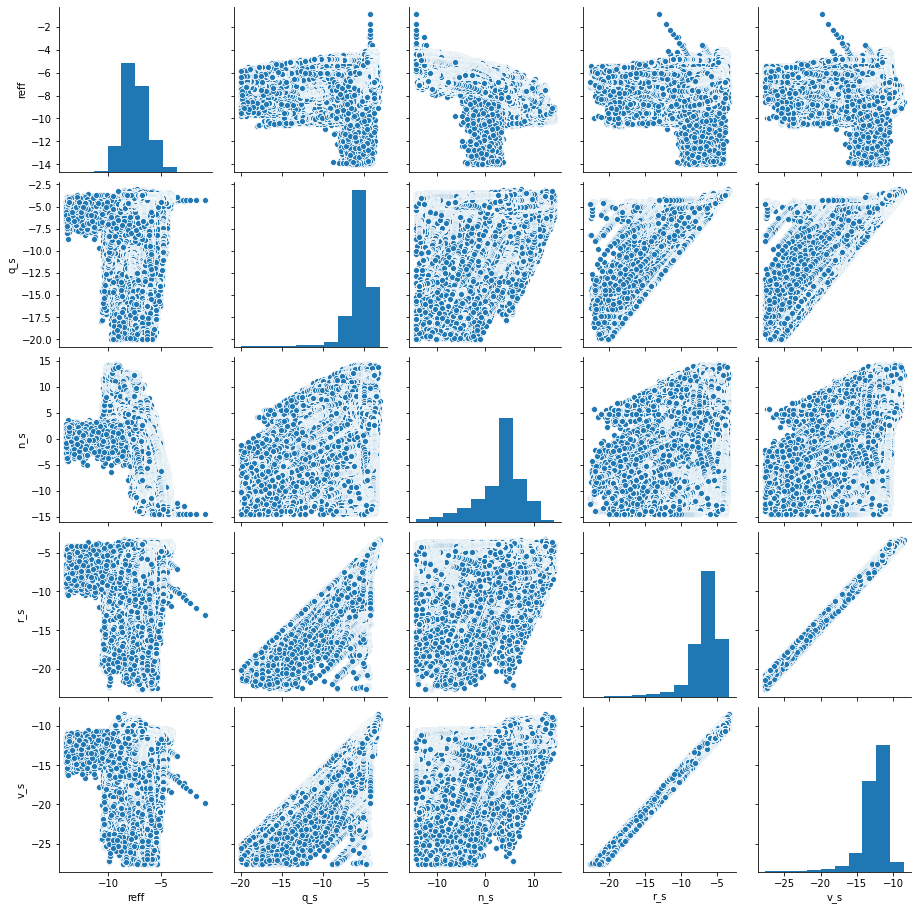

In [18]:
sns.pairplot(dataset_train[["reff","q_s","n_s","r_s","v_s"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("reff")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s    1497472.0  -5.625981  1.564510 -19.999056  -6.043895  -5.352562   
n_s    1497472.0   3.002751  4.767962 -14.498609   0.888632   4.286149   
r_s    1497472.0  -6.647272  2.116022 -22.616461  -7.363446  -6.278294   
v_s    1497472.0 -12.647079  2.017180 -27.628325 -13.182976 -12.245552   
liq_s  1497472.0   0.180346  0.258809   0.000000   0.000000   0.047522   

             75%        max  
q_s    -4.790572  -3.045322  
n_s     5.696892  14.304765  
r_s    -5.326367  -3.287717  
v_s   -11.496757  -8.502255  
liq_s   0.259569   0.999852

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [23]:
# pop does not work for multiple columns, use copy instead

labels = ['reff']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [24]:
train_labels.describe()

reff
count  1.497472e+06
mean  -7.446011e+00
std    1.122896e+00
min   -1.399829e+01
25%   -8.304172e+00
50%   -7.530746e+00
75%   -6.719151e+00
max   -9.142793e-01

In [25]:
train_dataset1.describe()

q_s           n_s           r_s           v_s         liq_s
count  1.497472e+06  1.497472e+06  1.497472e+06  1.497472e+06  1.497472e+06
mean  -5.625981e+00  3.002751e+00 -6.647272e+00 -1.264708e+01  1.803458e-01
std    1.564510e+00  4.767962e+00  2.116022e+00  2.017180e+00  2.588091e-01
min   -1.999906e+01 -1.449861e+01 -2.261646e+01 -2.762832e+01  0.000000e+00
25%   -6.043895e+00  8.886317e-01 -7.363446e+00 -1.318298e+01  0.000000e+00
50%   -5.352562e+00  4.286149e+00 -6.278294e+00 -1.224555e+01  4.752231e-02
75%   -4.790572e+00  5.696892e+00 -5.326367e+00 -1.149676e+01  2.595686e-01
max   -3.045322e+00  1.430476e+01 -3.287717e+00 -8.502255e+00  9.998519e-01

### Normalize the features

In [26]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_val_data1 = norm(val_dataset1,train_stats1)

In [27]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s    1497472.0  5.058948e-07  1.0 -9.186950 -0.267122  0.174763  0.533975   
n_s    1497472.0  2.006242e-07  1.0 -3.670616 -0.443401  0.269171  0.565051   
r_s    1497472.0  3.293137e-07  1.0 -7.546799 -0.338453  0.174373  0.624240   
v_s    1497472.0  2.285249e-06  1.0 -7.426826 -0.265667  0.199053  0.570262   
liq_s  1497472.0 -1.257380e-07  1.0 -0.696829 -0.696829 -0.513210  0.306105   

            max  
q_s    1.649500  
n_s    2.370408  
r_s    1.587675  
v_s    2.054761  
liq_s  3.166450

### Normalize the labels

In [28]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count      mean       std        min       25%       50%       75%  \
reff  1497472.0 -7.446011  1.122896 -13.998287 -8.304172 -7.530746 -6.719151   

           max  
reff -0.914279

In [29]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [30]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H2(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H1(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H1":
        model = build_model_relu_Adam_H1(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H2":
        model = build_model_relu_Adam_H2(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [31]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(5,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [33]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.8224846 ],
       [-0.8309382 ],
       [-0.8329422 ],
       [-0.834445  ],
       [-0.83564234],
       [-0.83743656],
       [-0.83811843],
       [-0.83870286],
       [-0.83920586],
       [-0.8396373 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [34]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [35]:
nsize = 8
activ = "ReLU_Adam_H1"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0476,  mae:0.0935,  mse:0.0476,  val_loss:0.0375,  val_mae:0.0713,  val_mse:0.0375,  
.........................................

Text(0, 0.5, 'MAE')

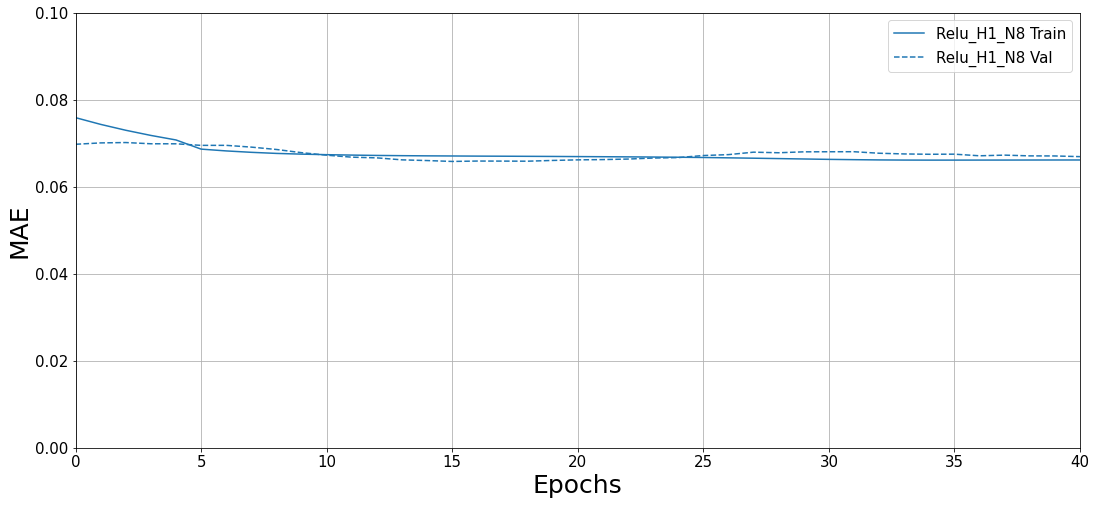

In [36]:
histories['ReLU_H1_n8'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.,0.1])
plt.ylabel('MAE')

In [37]:
nsize = 16
model2 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0409,  mae:0.0796,  mse:0.0409,  val_loss:0.0344,  val_mae:0.0605,  val_mse:0.0344,  
...................................

In [38]:
histories['ReLU_H1_n16'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.1])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

In [39]:
nsize = 8
activ = "ReLU_Adam_H2"
model3 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0483,  mae:0.0927,  mse:0.0483,  val_loss:0.0361,  val_mae:0.0671,  val_mse:0.0361,  
........................

Text(0, 0.5, 'MAE')

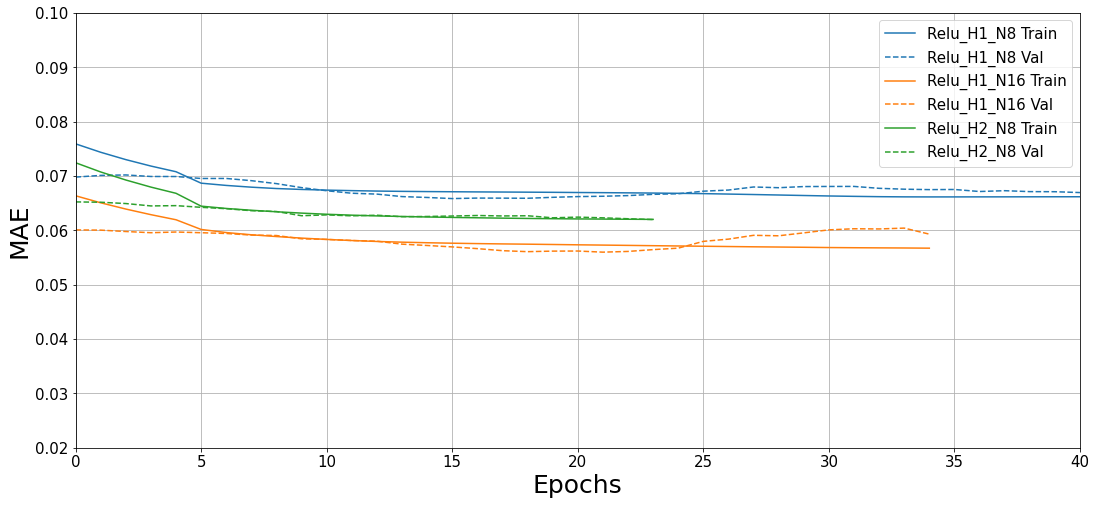

In [40]:
histories['ReLU_H2_n8'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.1])
plt.ylabel('MAE')

In [41]:
nsize = 16
model4 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0393,  mae:0.0771,  mse:0.0393,  val_loss:0.0345,  val_mae:0.0605,  val_mse:0.0345,  
....................................................

Text(0, 0.5, 'MAE')

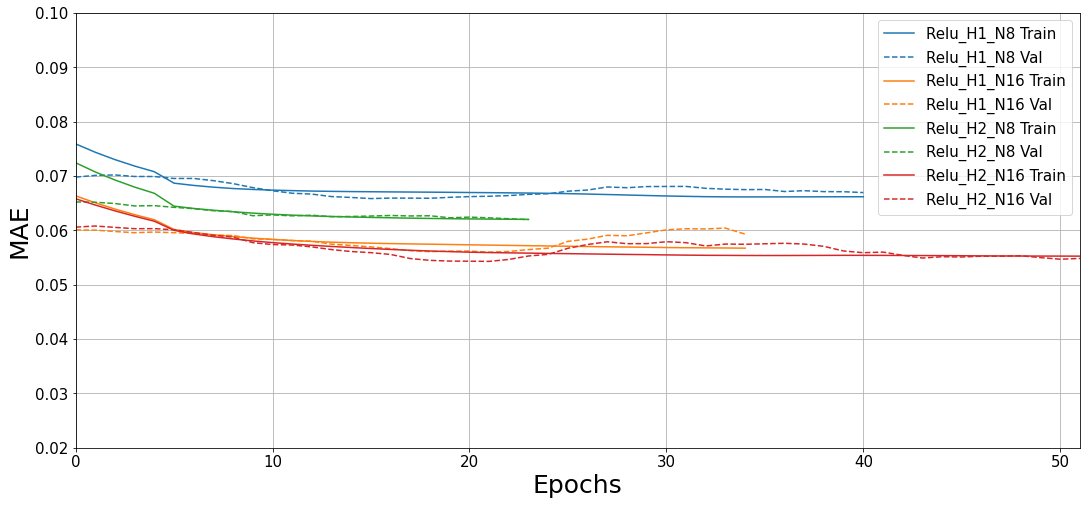

In [42]:
histories['ReLU_H2_n16'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.1])
plt.ylabel('MAE')

In [43]:
nsize = 32
model5 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history5 = model5.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0378,  mae:0.0730,  mse:0.0378,  val_loss:0.0331,  val_mae:0.0551,  val_mse:0.0331,  
.......................................

Text(0, 0.5, 'MAE')

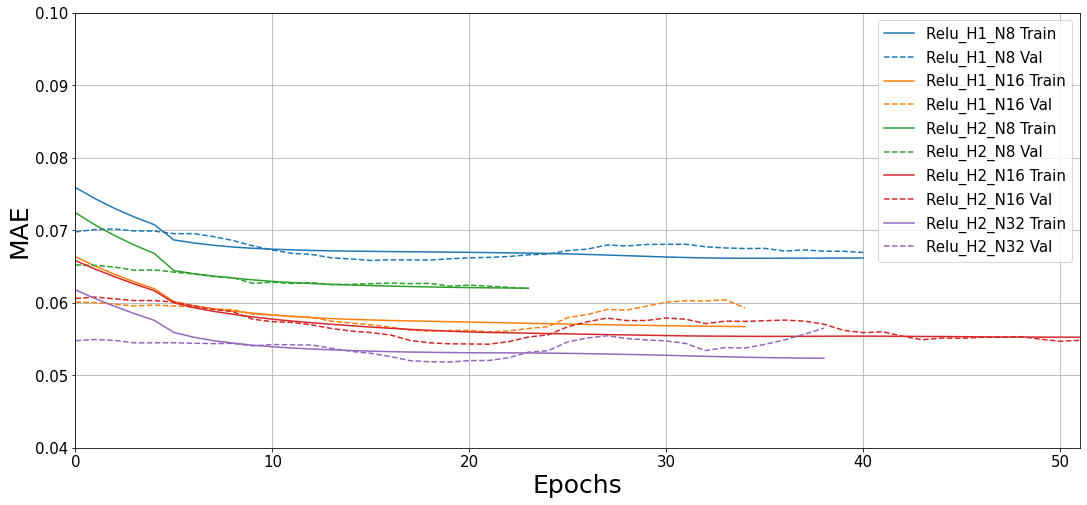

In [46]:
histories['ReLU_H2_n32'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.1])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

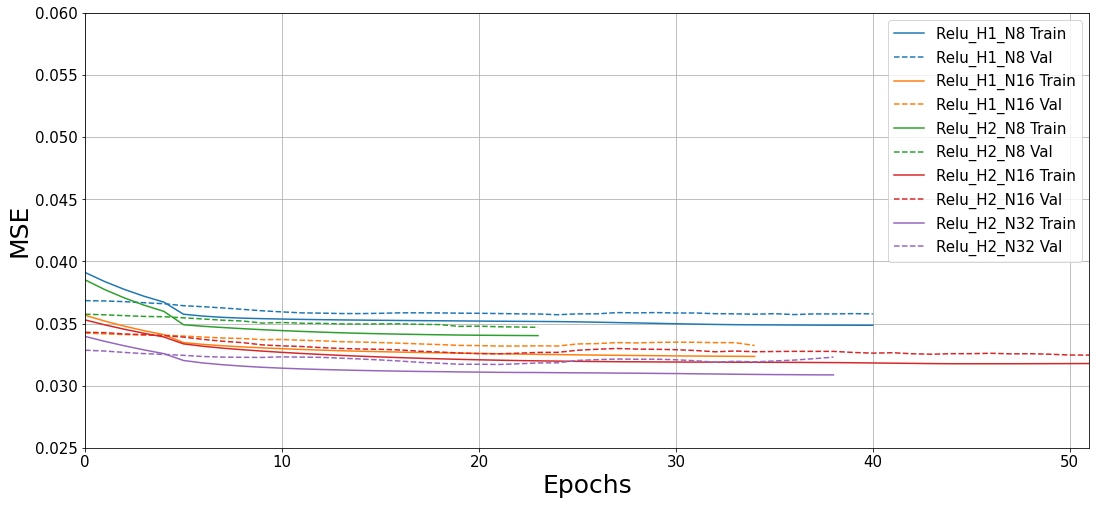

In [50]:

plotter.plot(histories, metric = "mse")
plt.ylim([0.025, 0.06])
plt.ylabel('MSE')

In [51]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

320385/320385 - 7s - loss: 0.0356 - mae: 0.0647 - mse: 0.0356
Testing set for model 1, Mean Abs Error:    0.06474


In [52]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

320385/320385 - 7s - loss: 0.0333 - mae: 0.0560 - mse: 0.0333
Testing set for model 2, Mean Abs Error:              0.05605


In [53]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

320385/320385 - 8s - loss: 0.0347 - mae: 0.0591 - mse: 0.0347
Testing set for model 3, Mean Abs Error:              0.05915


In [54]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

320385/320385 - 7s - loss: 0.0323 - mae: 0.0519 - mse: 0.0323
Testing set for model 4, Mean Abs Error:              0.05187


In [55]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

320385/320385 - 7s - loss: 0.0316 - mae: 0.0506 - mse: 0.0316
Testing set for model 5, Mean Abs Error:              0.05062


In [56]:
mae = [ mae1, mae2, mae3, mae4, mae5 ]
mae

[0.06474478, 0.05604897, 0.059148088, 0.051872294, 0.050623357]

In [57]:
mse = [ mse1, mse2, mse3, mse4, mse5 ]
mse

[0.03556892, 0.033273857, 0.034715086, 0.032287113, 0.03157569]

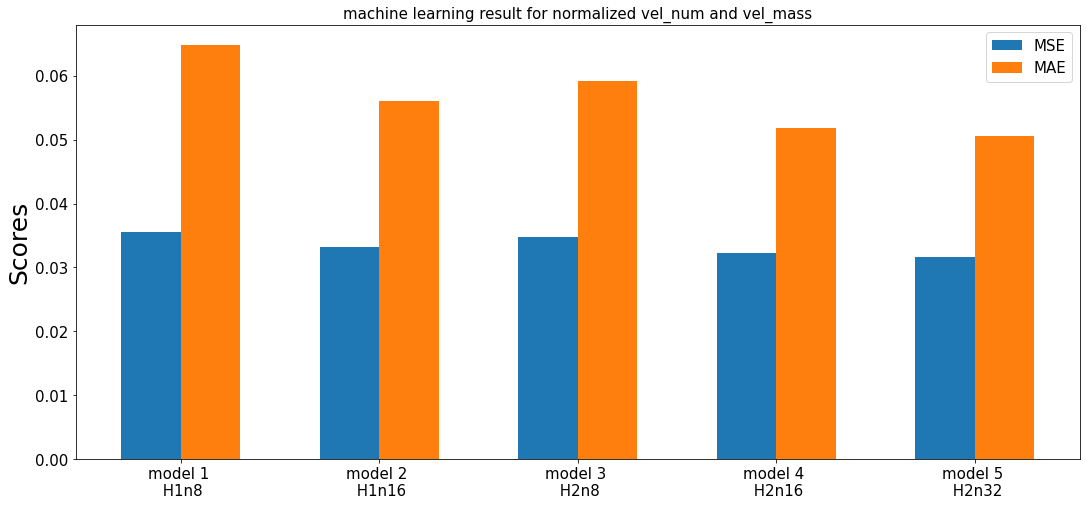

In [58]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [ 'model 1 \n H1n8',
 'model 2 \n H1n16',
 'model 3 \n H2n8',
 'model 4 \n H2n16',
 'model 5 \n H2n32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized vel_num and vel_mass')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [59]:
test_true_num  = np.exp(test_labels.pop('reff'))

In [60]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [61]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["reff"])

In [62]:
p1.describe()

reff
count  320385.000000
mean        0.004023
std         0.984982
min        -2.882145
25%        -0.748476
50%        -0.079082
75%         0.638272
max         2.937054

In [63]:
train_labels_stats

count      mean       std        min       25%       50%       75%  \
reff  1497472.0 -7.446011  1.122896 -13.998287 -8.304172 -7.530746 -6.719151   

           max  
reff -0.914279

In [64]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [65]:
test_predict1.describe()

reff
count  320385.000000
mean        0.001145
std         0.001735
min         0.000023
25%         0.000252
50%         0.000534
75%         0.001195
max         0.015796

In [66]:
test_predict1_num  = test_predict1['reff']

In [67]:

p2 = pd.DataFrame(data=model2.predict(normed_test_data1), columns=["reff"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_num  = test_predict2['reff']

In [68]:

p3 = pd.DataFrame(data=model3.predict(normed_test_data1), columns=["reff"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_num  = test_predict3['reff']

In [69]:

p5 = pd.DataFrame(data=model5.predict(normed_test_data1), columns=["reff"])

test_predict5 = np.exp(backtransform(p5,train_labels_stats))

test_predict5_num  = test_predict5['reff']

### Maybe the ordering of the arrays is different? 

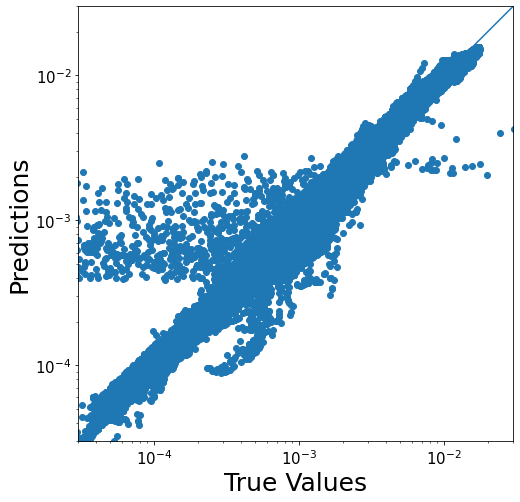

In [70]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 3e-5, 3e-2

a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict1_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

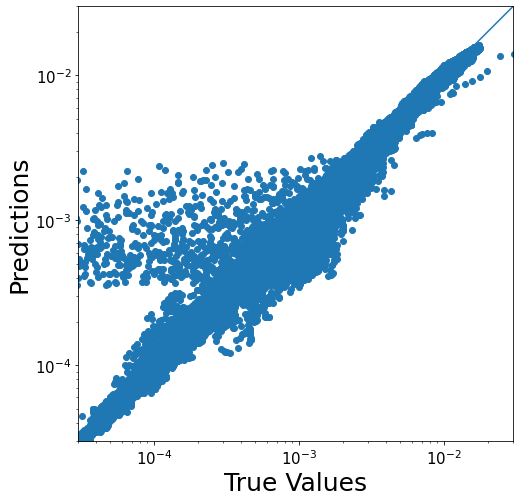

In [71]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict2_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

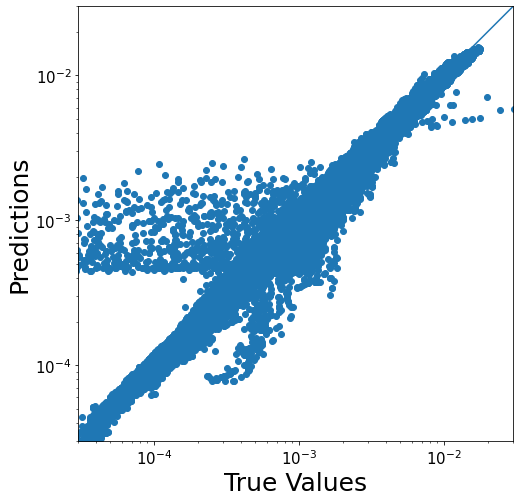

In [72]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict3_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

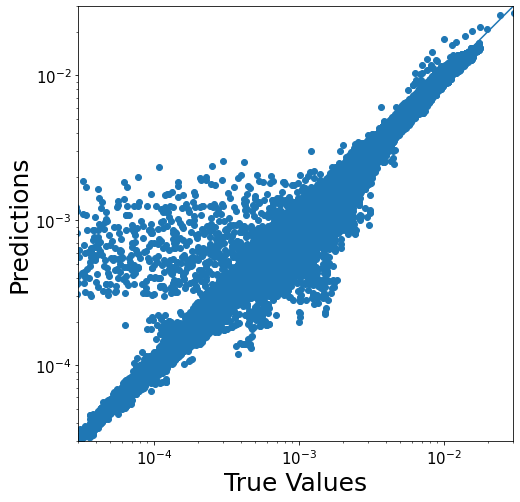

In [73]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict5_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [74]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [75]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [76]:
features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liquid_rimedsnow'
labels   = 'reff_rimedsnow'
filename = 'saved_model_v2/reff_rimedsnow_model1_'+version+'.nc'
logtransform = np.array([True, True, True, True, False], dtype=bool)

save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,filename)
save2netcdf(model2,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_rimedsnow_model2_'+version+'.nc')
save2netcdf(model3,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_rimedsnow_model3_'+version+'.nc')
save2netcdf(model4,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_rimedsnow_model4_'+version+'.nc')
save2netcdf(model5,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_rimedsnow_model5_'+version+'.nc')




Saving model to saved_model_v2/reff_rimedsnow_model1_02.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liquid_rimedsnow
  Labels:     reff_rimedsnow
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 8), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 8), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 1), Activation: linear
Saving model to saved_model_v2/reff_rimedsnow_model2_02.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liquid_rimedsnow
  Labels:     reff_rimedsnow
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (5, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/reff_rimedsnow_model3_02.nc
  Features:   q_rimedsnow, n_rimedsnow, rma

In [77]:
train_stats1

count       mean       std        min        25%        50%  \
q_s    1497472.0  -5.625981  1.564510 -19.999056  -6.043895  -5.352562   
n_s    1497472.0   3.002751  4.767962 -14.498609   0.888632   4.286149   
r_s    1497472.0  -6.647272  2.116022 -22.616461  -7.363446  -6.278294   
v_s    1497472.0 -12.647079  2.017180 -27.628325 -13.182976 -12.245552   
liq_s  1497472.0   0.180346  0.258809   0.000000   0.000000   0.047522   

             75%        max  
q_s    -4.790572  -3.045322  
n_s     5.696892  14.304765  
r_s    -5.326367  -3.287717  
v_s   -11.496757  -8.502255  
liq_s   0.259569   0.999852